<a href="https://colab.research.google.com/github/qmaruf/fastai/blob/master/fast_ai_largest_object_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys
print (sys.version)

import sys
print (sys.version)

# ! pip3 install fastai==0.7.0
# ! pip3 install torchtext==0.2.3

# ! pip3 install torch
# ! pip3 install torchvision

%matplotlib inline
%reload_ext autoreload
%autoreload 2

# from fastai.conv_learner import *
# from fastai.dataset import *

import torch
import torch.nn as nn
from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import torch.optim as optim
import time, copy
torch.cuda.set_device(0)

# !mkdir data
# !wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar -P data/
# !wget https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip -P data/
# !tar -xf data/VOCtrainval_06-Nov-2007.tar -C data/
# !unzip data/PASCAL_VOC.zip -d data/
# !rm -rf data/PASCAL_VOC.zip data/VOCtrainval_06-Nov-2007.tar

3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]


In [0]:
import collections
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1971)

In [4]:
PATH = Path('data/PASCAL_VOC/')
list(PATH.iterdir())

[PosixPath('data/PASCAL_VOC/pascal_train2012.json'),
 PosixPath('data/PASCAL_VOC/pascal_train2007.json'),
 PosixPath('data/PASCAL_VOC/pascal_test2007.json'),
 PosixPath('data/PASCAL_VOC/pascal_val2012.json'),
 PosixPath('data/PASCAL_VOC/pascal_val2007.json')]

In [0]:
train_json = json.load((PATH/'pascal_train2007.json').open())

In [6]:
train_json.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [0]:
IMAGES, TYPE, ANNOTATIONS, CATEGORIES = ['images', 'type', 'annotations', 'categories']

In [8]:
images_dir = Path('./data/VOCdevkit/VOC2007/JPEGImages/')
next(images_dir.iterdir())

PosixPath('data/VOCdevkit/VOC2007/JPEGImages/006595.jpg')

In [0]:
# dictionary to keep image_id vs bbox and and corresponding category
annotation_dict = collections.defaultdict(lambda:[])
for item in train_json[ANNOTATIONS]:
#     print (item['image_id'])
#     print (item['bbox'])
#     print (item['category_id'])
    annotation_dict[item['image_id']].append((item['category_id'], item['bbox']))
#     break

In [10]:
len(annotation_dict)

2501

In [0]:
# dictionary to keep image id to image path
image_id_to_filename = dict()
for item in train_json[IMAGES]:
    image_id_to_filename[item['id']]= images_dir/item['file_name']

In [0]:
image_id_to_category = dict()
for item in train_json[CATEGORIES]:
    image_id_to_category[item['id']]=item['name']

In [0]:
# image_id_to_filename

In [0]:
def coord_to_hw(bb):
    return np.array([bb[0], bb[1], bb[2]-bb[0]+1, bb[3]-bb[1]+1])

def hw_to_coord(bb):
    return np.array([bb[0], bb[1], bb[0]+bb[2], bb[1]+bb[3]])

def draw_image(image, figsize=None, ax=None):
    if ax is None: 
        fig, ax = plt.subplots()
    ax.imshow(image)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_bbox(ax, bbox):
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, edgecolor='white', linewidth=2)
    ax.add_patch(rect)
    
def add_text(ax, bb, txt):
    text = ax.text(bb[0], bb[1], txt, fontsize=14, color='white', weight='bold', backgroundcolor='black') 
    
def read_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

from sklearn.preprocessing import LabelEncoder

class CategoryUtil:
    def __init__(self, labels):
        self.labels = np.unique(labels)
        self.encode_dict = dict()
        self.decode_dict = dict()
        for id, label in enumerate(self.labels):
            self.encode_dict[label] = id
            self.decode_dict[id] = label
            
    def encode(self, label):
        return self.encode_dict[label]
    
    def decode(self, id):
        return self.decode_dict[id]

(15, [184, 61, 95, 138])
(13, [89, 77, 314, 259])


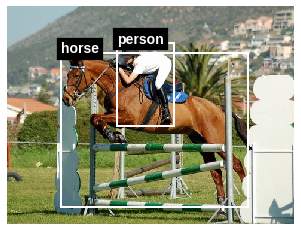

In [14]:
image_id = 17
image = read_image(str(image_id_to_filename[image_id]))
ax = draw_image(image)
for bbox in annotation_dict[image_id]:
    print (bbox)
    draw_bbox(ax, bbox[1])
    add_text(ax, bbox[1], image_id_to_category[bbox[0]])

In [0]:
annotation_dict_large = dict()
for image_id in annotation_dict:
    bboxes = (annotation_dict[image_id])
    lrg_bb = sorted(bboxes, key=lambda x: x[1][2]*x[1][3], reverse=True)[0]
    annotation_dict_large[image_id]=lrg_bb

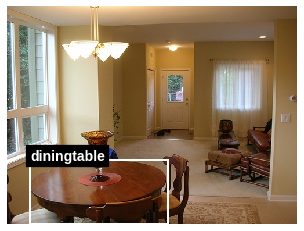

In [16]:
image_id = 235
image = read_image(str(image_id_to_filename[image_id]))
ax = draw_image(image)
draw_bbox(ax, annotation_dict_large[image_id][1])
add_text(ax, annotation_dict_large[image_id][1], image_id_to_category[annotation_dict_large[image_id][0]])

In [0]:
df = pd.DataFrame(
{
    'image_path': [image_id_to_filename[id] for id in annotation_dict_large],
    'category': [image_id_to_category[annotation_dict_large[id][0]] for id in annotation_dict_large],
    'bbox': [','.join(list(map(str, hw_to_coord(annotation_dict_large[id][1])))) for id in annotation_dict_large]
})


In [0]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from glob import glob
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

input_size = 224
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

class MyCustomDataset(Dataset):
    def __init__(self, df, phase):
        self.df = df
        self.transforms = data_transforms[phase]              
        
    def __getitem__(self, index):
        image = read_image(str(self.df.iloc[index]['image_path']))
        image = self.transforms(image)        
#         label = torch.tensor( self.df.iloc[index]['category'])
        label = catutil.encode(self.df.iloc[index]['category'])
        return image, label

    def __len__(self):
        return self.df.shape[0]


df = df.sample(frac=1)

n_train = int(df.shape[0]*80/100)
n_val = df.shape[0] - n_train
df_train = df.head(n_train)
df_val = df.tail(n_val)

catutil = CategoryUtil(df.category)

dataset = MyCustomDataset(df_train, 'train')
train_data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

dataset = MyCustomDataset(df_val, 'val')
val_data_loader = DataLoader(dataset, batch_size=16, shuffle=False)

dataloaders_dict = {
    'train': train_data_loader,
    'val': val_data_loader
}

In [21]:
df.head()

,bbox,category,image_path
2260,"0,81,500,375",car,data/VOCdevkit/VOC2007/JPEGImages/009045.jpg
2219,"230,97,370,313",bird,data/VOCdevkit/VOC2007/JPEGImages/008926.jpg
1095,"2,36,241,500",person,data/VOCdevkit/VOC2007/JPEGImages/004322.jpg
313,"19,25,82,72",aeroplane,data/VOCdevkit/VOC2007/JPEGImages/001332.jpg
59,"7,95,491,232",aeroplane,data/VOCdevkit/VOC2007/JPEGImages/000256.jpg


In [0]:
# for data in data_loader:
#     print (data[0])
#     break

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [0]:
import torchvision as tv

In [0]:
model_ft = tv.models.resnet101(pretrained=True)
set_parameter_requires_grad(model_ft, feature_extracting=True)
num_ftrs = model_ft.fc.in_features
num_classes = 20
model_ft.fc = nn.Linear(num_ftrs, num_classes)

In [25]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [26]:
data_transforms['train']

Compose(
    ToPILImage()
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [27]:
len(np.unique(df.category.values))

20

In [0]:
# torch.cuda.get_device_name(1)

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

cuda:0


In [0]:
model_ft = model_ft.to(device)

In [0]:
params_to_update = []
for name, param in model_ft.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)

In [0]:
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [0]:
criterion = nn.CrossEntropyLoss()
num_epochs=10    

In [35]:
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=False)

Epoch 0/9
----------
train Loss: 1.8917 Acc: 0.4835
val Loss: 1.0609 Acc: 0.7226

Epoch 1/9
----------
train Loss: 1.1430 Acc: 0.6910
val Loss: 0.7756 Acc: 0.7944

Epoch 2/9
----------
train Loss: 0.9473 Acc: 0.7410
val Loss: 0.6880 Acc: 0.7924

Epoch 3/9
----------
train Loss: 0.8709 Acc: 0.7440
val Loss: 0.6542 Acc: 0.7984

Epoch 4/9
----------
train Loss: 0.8375 Acc: 0.7470
val Loss: 0.6111 Acc: 0.8084

Epoch 5/9
----------
train Loss: 0.7795 Acc: 0.7685
val Loss: 0.5974 Acc: 0.8044

Epoch 6/9
----------
train Loss: 0.7256 Acc: 0.7820
val Loss: 0.5957 Acc: 0.8024

Epoch 7/9
----------
train Loss: 0.7555 Acc: 0.7780
val Loss: 0.6209 Acc: 0.7924

Epoch 8/9
----------
train Loss: 0.7173 Acc: 0.7830
val Loss: 0.5961 Acc: 0.8124

Epoch 9/9
----------
train Loss: 0.7070 Acc: 0.7765
val Loss: 0.5799 Acc: 0.8064

Training complete in 9m 2s
Best val Acc: 0.812375


In [0]:
#==============

def denormalize(image, _mean=None, _std=None):
    if _mean is None and _std is None:
        _mean = [0.485, 0.456, 0.406]
        _std = [0.229, 0.224, 0.225]
    for i in range(3):
        image[:, i, :, :] = image[:, i, :, :] * _std[i] + _mean[i]
    return image

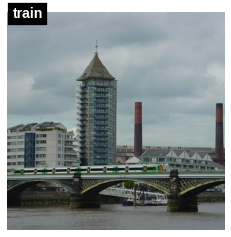

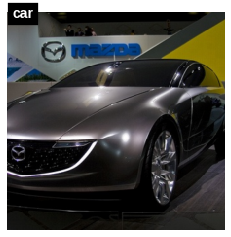

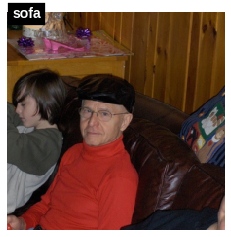

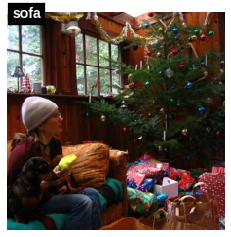

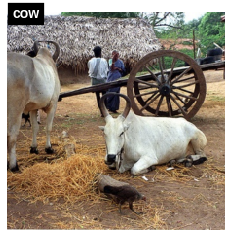

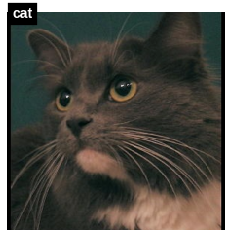

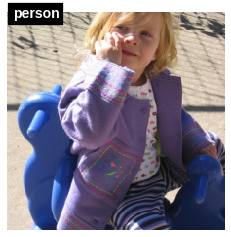

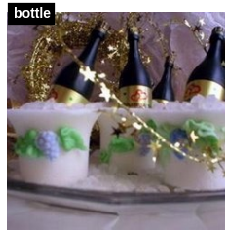

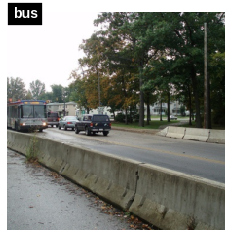

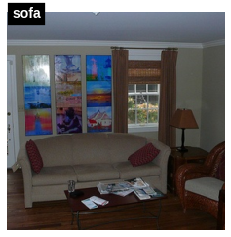

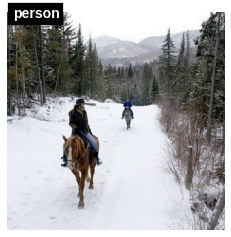

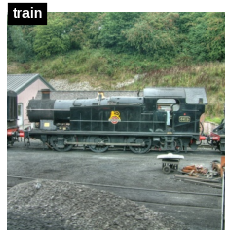

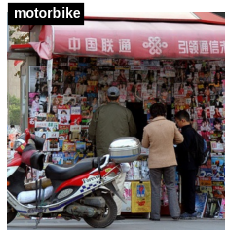

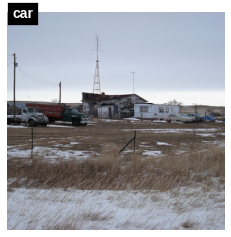

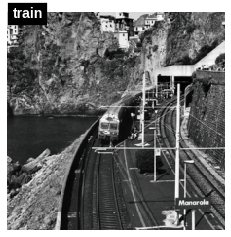

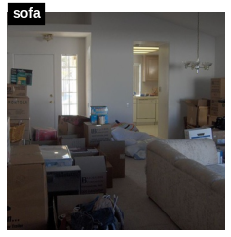

In [63]:
to_pil = transforms.ToPILImage()
for inputs, labels in val_data_loader:
    inputs, labels = inputs.cuda(), labels.cuda()
    predictions = model_ft(inputs)
    inputs = denormalize(inputs)
    for inp, lbl in zip(inputs, labels):
        ax = draw_image(to_pil(inp.cpu()))
        lbl = catutil.decode(lbl.item())
        add_text(ax, [5, 5], lbl)
    break

In [0]:
train_hist = [h.item() for h in hist]

Text(0, 0.5, 'validation accuracy')

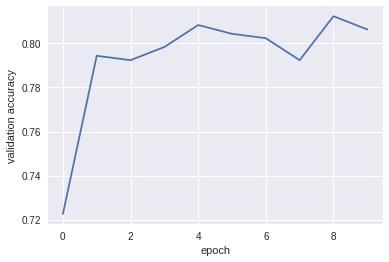

In [67]:
plt.plot(train_hist)
plt.xlabel('epoch')
plt.ylabel('validation accuracy')